<a href="https://colab.research.google.com/gist/NeDa-Y/ac970dcbd31a2764bbcb9fc95573114c/image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 376 kB 31.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=99216ceab1ad9fded1ee2cffbc87a42ee4fb99cf89ca14501bb3ad673dc1edce
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4135f96cc2c89aaa2bacd9d6818263afc2f391c8ff86e4ff03b208a2dea77463
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Download Dataset**

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 40.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
CSV_FILE="/content/Human-Segmentation-Dataset-master/train.csv"
Data_DIR='/content/'

In [ ]:
DEVICE="Cuda"
EPOCHS=5
LR=0.003
IMAGE_SIZE=120
BATCH_SIZE=16
ENCODER='timm-efficientnet-b1'
WEIGHTS='imagenet'


In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/ 255.0


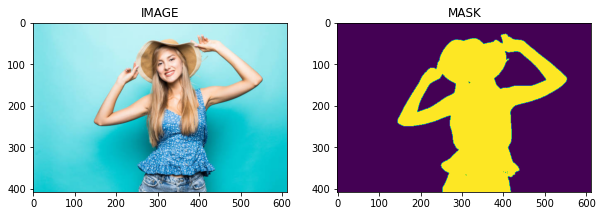

In [ ]:
f, (ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
row=df.iloc[1]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/ 255.0

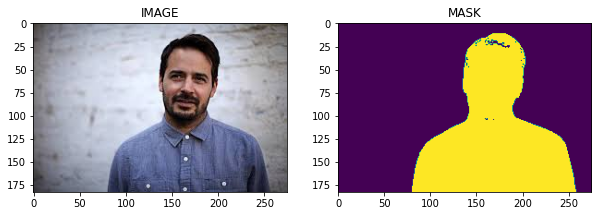

In [ ]:
f, (ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

# **Creating Train and Test Dataset**

In [ ]:
train_df, test_df= train_test_split(df, test_size=0.2)

# **Augmentation**

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
         A.Resize(IMAGE_SIZE,IMAGE_SIZE),
         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.5)           
  ])


def get_test_augs():
  return A.Compose([
         A.Resize(IMAGE_SIZE,IMAGE_SIZE),        
  ])

# **Creating Custom Dataset**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from albumentations import augmentations
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row= self.df.iloc[idx]
    image_path=row.images
    mask_path= row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)   #(h,w,c)
    mask=np.expand_dims(mask, axis= -1)

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image= data['image']
      mask= data['mask']

    # (h,w,c) -> (c,h,w)

    image= np.transpose(image, (2,0,1)).astype(np.float32)
    mask= np.transpose(mask, (2,0,1)).astype(np.float32)
    image=torch.Tensor(image) / 255.0
    mask= torch.round(torch.Tensor(mask) / 255.0)
    
    return image, mask

      


In [ ]:
trainset= SegmentationDataset(train_df, get_train_augs())
testset= SegmentationDataset(test_df, get_test_augs())

In [ ]:
print (f"Size of Trainset : {len(trainset)}")
print (f"Size of Testset : {len(testset)}")


Size of Trainset : 232
Size of Testset : 58


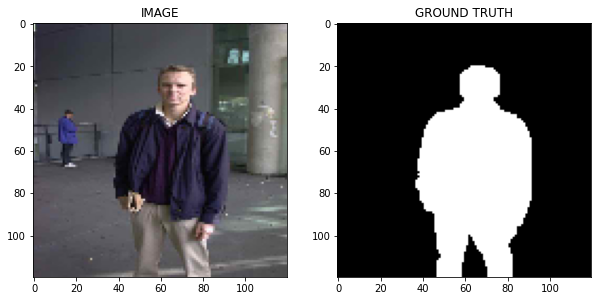

In [ ]:
idx=5
image, mask=trainset[idx]
helper.show_image(image, mask)

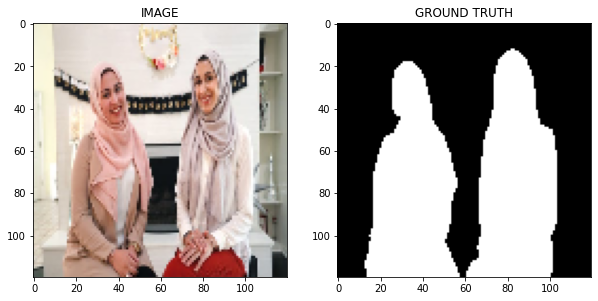

In [ ]:
idx=9
image, mask=trainset[idx]
helper.show_image(image, mask)

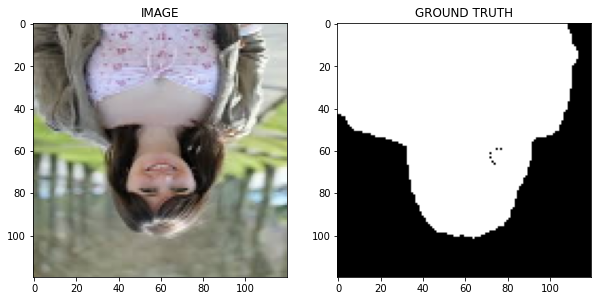

In [ ]:
idx=10
image, mask=trainset[idx]
helper.show_image(image, mask)

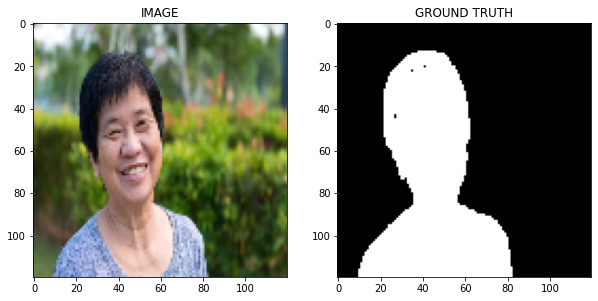

In [ ]:
idx=50
image, mask=trainset[idx]
helper.show_image(image, mask)

# **Load Dataset into Batches**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainLoader = DataLoader (trainset, batch_size=BATCH_SIZE,shuffle=True)
testLoader= DataLoader (testset, batch_size=BATCH_SIZE)
print (f'Total Number of batches in trainloader: {len(trainLoader)}')
print (f'Total Number of batches in testloader: {len(testLoader)}')


Total Number of batches in trainloader: 15
Total Number of batches in testloader: 4


In [ ]:
for image, mask in trainLoader:
  break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')


One batch image shape: torch.Size([16, 3, 120, 120])
One batch mask shape: torch.Size([16, 1, 120, 120])


# **Creating segmentation model**

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc= smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1= DiceLoss(mode="binary")(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model= SegmentationModel()
#model.to(DEVICE)

In [ ]:
model

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss=0.0

  for images, masks in tqdm(data_loader):
    #images=images.to(DEVICE)
    #masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss= model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss / len(data_loader)


def eval_fn(data_loader, model):

  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      #images=images.to(DEVICE)
      #masks=masks.to(DEVICE)
      logits, loss=model(images, masks)
      
      total_loss+= loss.item()

    return total_loss / len(data_loader)

In [ ]:
optimizer= torch.optim.Adam(model.parameters(), lr=LR)

best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss= train_fn(trainLoader, model, optimizer)
  test_loss= eval_fn(testLoader, model)

  

  print(f"EPOCH : {i+1} Train_loss: {train_loss} Test_loss :{test_loss}")


In [ ]:
idx=20
image, mask= testset[idx]

logits_mask= model(image.unsqueeze(0))
pred_mask= torch.sigmoid(logits_mask)
pred_mask= (pred_mask >0.5)* 1.0
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze())